In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahboobmustafa","key":"6c497a86c547a845eee466d0ac62836c"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [0]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 70 Nov 19 15:46 kaggle.json
{"username":"mahboobmustafa","key":"6c497a86c547a845eee466d0ac62836c"}

In [0]:
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 3.1MB/s 
     |████████████████████████████████| 5.3MB 9.1MB/s 
     |████████████████████████████████| 112kB 44.6MB/s 
     |████████████████████████████████| 112kB 47.1MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 


In [0]:
!kaggle datasets download -d tanlikesmath/diabetic-retinopathy-resized

100% 7.25G/7.25G [00:43<00:00, 164MB/s]
100% 7.25G/7.25G [00:43<00:00, 181MB/s]


In [0]:
!unzip diabetic-retinopathy-resized.zip

In [0]:
import glob
print(len(glob.glob('resized_train/resized_train/*')))
print(len(glob.glob('resized_train_cropped/resized_train_cropped/*')))

35126
35108


In [0]:
!rm -rf resized_train
! rm -rf trainLabels.csv

In [0]:
import os
from glob import glob
from skimage.io import imread

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

%matplotlib inline 

from keras.utils.np_utils import to_categorical

# Tensorflow, Sklearn & Keras related imports
import tensorflow as tf

from sklearn.model_selection import train_test_split

from keras import backend as K
from keras.applications.inception_v3 import preprocess_input

from keras.applications.vgg16 import VGG16
# from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
from keras.layers import BatchNormalization
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [0]:
labels = pd.read_csv('trainLabels_cropped.csv')
updated_labels = pd.DataFrame()
updated_labels['image'] = labels['image']
updated_labels['level'] = labels['level']

In [0]:
root_directory = './resized_train_cropped/resized_train_cropped'

In [0]:
check_path = os.path.exists
split_name = lambda x: x.split('_')[0]
image_path = lambda x: os.path.join(root_directory,'{}.jpeg'.format(x))
get_level  = lambda x: to_categorical(x,1+dataset['level'].max())
check_left_or_right = lambda x: 1 if x.split('_')[-1]=='left' else 0
resample_data = lambda x: x.sample(300, replace = True)

In [0]:
dataset = pd.DataFrame()

dataset['image'] = updated_labels['image']
dataset['level'] = updated_labels['level']

dataset['p_id'] = updated_labels['image'].map(split_name)
dataset['path'] = updated_labels['image'].map(image_path)

dataset['path_exists'] = dataset['path'].map(check_path)
dataset['l_r_eye'] = dataset['image'].map(check_left_or_right)
dataset['level_cat'] = dataset['level'].map(get_level)

In [0]:
print(dataset.shape)
# Removing nulls and rows where path does not exist (since we are working on a subset)
dataset.dropna(inplace = True)
dataset = dataset[dataset['path_exists']]
print(dataset.shape)

(35108, 7)
(35108, 7)


In [0]:
dataset['level'].unique()

array([0, 1, 2, 4, 3])

In [0]:
level_0_samples = dataset[dataset['level']==0].sample(n=5)
level_1_samples = dataset[dataset['level']==1].sample(n=5)
level_2_samples = dataset[dataset['level']==2].sample(n=5)
level_3_samples = dataset[dataset['level']==3].sample(n=5)
level_4_samples = dataset[dataset['level']==4].sample(n=5)

In [0]:
import pywt
import cv2

In [0]:

def take_wavelet(path):
    image = cv2.imread(path)
    coeffs2 = pywt.dwt2(image, 'bior1.3')
    LL, (LH, HL, HH) = coeffs2
    return [LL, LH, HL, HH]

In [0]:
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

for path in level_0_samples['path']:
    [LL, LH, HL, HH] = take_wavelet(path)
    fig = plt.figure(figsize=(12, 3))
    for i, a in enumerate([HL, HH]):
        ax = fig.add_subplot(1, 4, i + 1)
        ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
        ax.set_title(titles[i], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()
plt.show()

In [0]:
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

for path in level_1_samples['path']:
    [LL, LH, HL, HH] = take_wavelet(path)
    fig = plt.figure(figsize=(12, 3))
    for i, a in enumerate([HL, HH]):
        ax = fig.add_subplot(1, 4, i + 1)
        ax.imshow(a/255, interpolation="nearest", cmap=plt.cm.gray)
        ax.set_title(titles[i+2], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()
plt.show()

In [0]:
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

for path in level_2_samples['path']:
    [LL, LH, HL, HH] = take_wavelet(path)
    fig = plt.figure(figsize=(12, 3))
    for i, a in enumerate([HL, HH]):
        ax = fig.add_subplot(1, 4, i + 1)
        ax.imshow(a/255, interpolation="nearest", cmap=plt.cm.gray)
        ax.set_title(titles[i+2], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()
plt.show()

In [0]:
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

for path in level_3_samples['path']:
    [LL, LH, HL, HH] = take_wavelet(path)
    fig = plt.figure(figsize=(12, 3))
    for i, a in enumerate([HL, HH]):
        ax = fig.add_subplot(1, 4, i + 1)
        ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
        ax.set_title(titles[i+2], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()
plt.show()

In [0]:
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

for path in level_4_samples['path']:
    [LL, LH, HL, HH] = take_wavelet(path)
    fig = plt.figure(figsize=(12, 3))
    for i, a in enumerate([HL, HH]):
        ax = fig.add_subplot(1, 4, i + 1)
        ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
        ax.set_title(titles[i+2], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()
plt.show()

In [0]:
dataset.head()

,image,level,p_id,path,path_exists,l_r_eye,level_cat
0,10_left,0,10,./resized_train_cropped/resized_train_cropped/...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
1,10_right,0,10,./resized_train_cropped/resized_train_cropped/...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
2,13_left,0,13,./resized_train_cropped/resized_train_cropped/...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
3,13_right,0,13,./resized_train_cropped/resized_train_cropped/...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
4,15_left,1,15,./resized_train_cropped/resized_train_cropped/...,True,1,"[0.0, 1.0, 0.0, 0.0, 0.0]"


In [0]:
from sklearn.utils import shuffle

x = dataset['path']
y = dataset['level']

x, y = shuffle(x, y, random_state=77)

(29841,) (29841,) (5267,) (5267,)


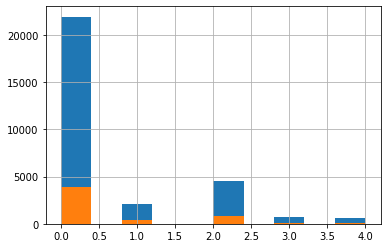

In [0]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,stratify=y, random_state=32)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()

In [0]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (512, 512))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [0]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img


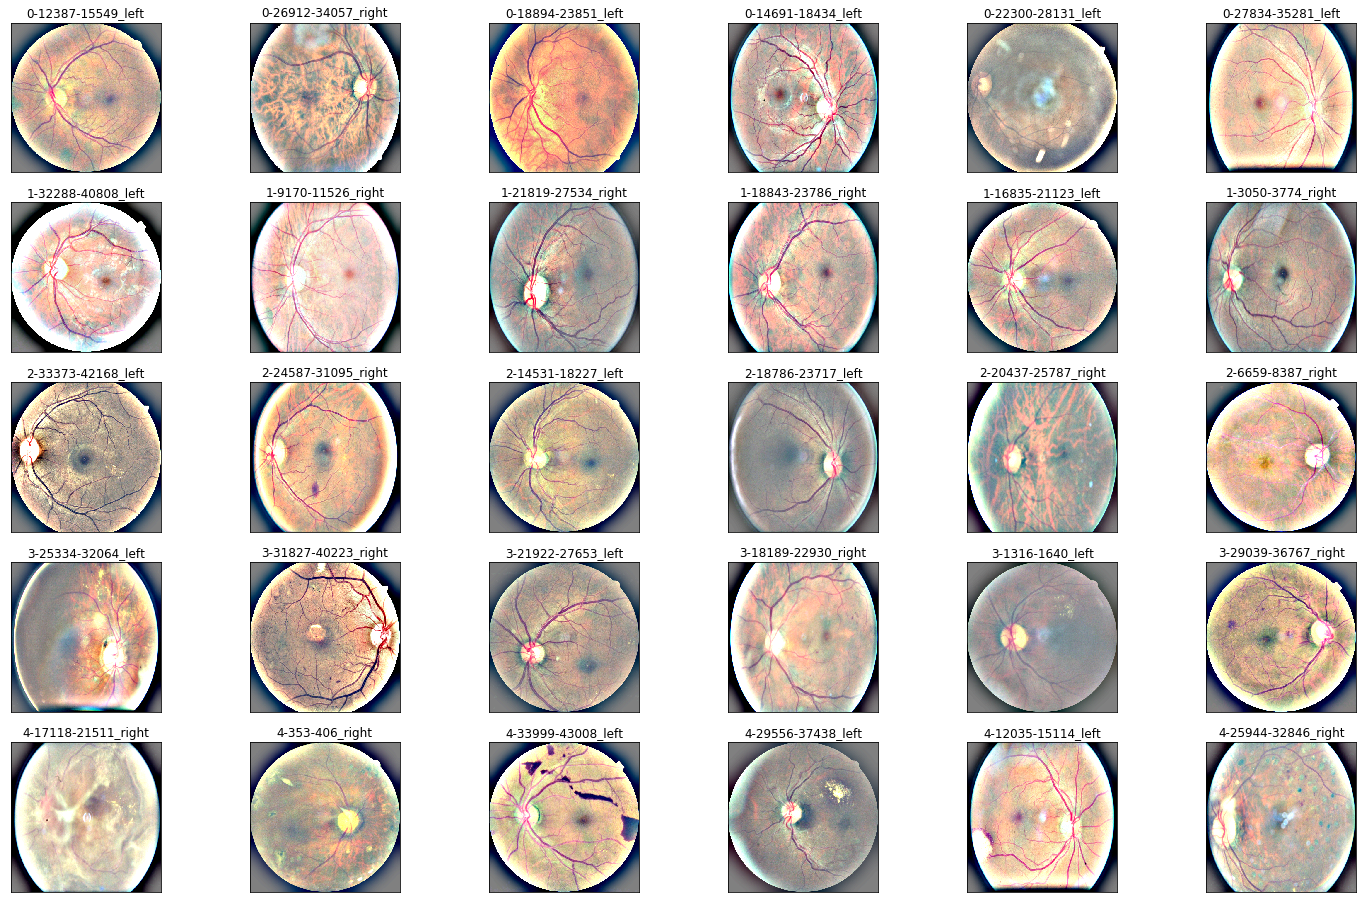

In [0]:
NUM_SAMP=5
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(dataset.loc[dataset['level'] == class_id].sample(NUM_SAMP, random_state=32).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        image = load_ben_color(row['path'],sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['image']) )

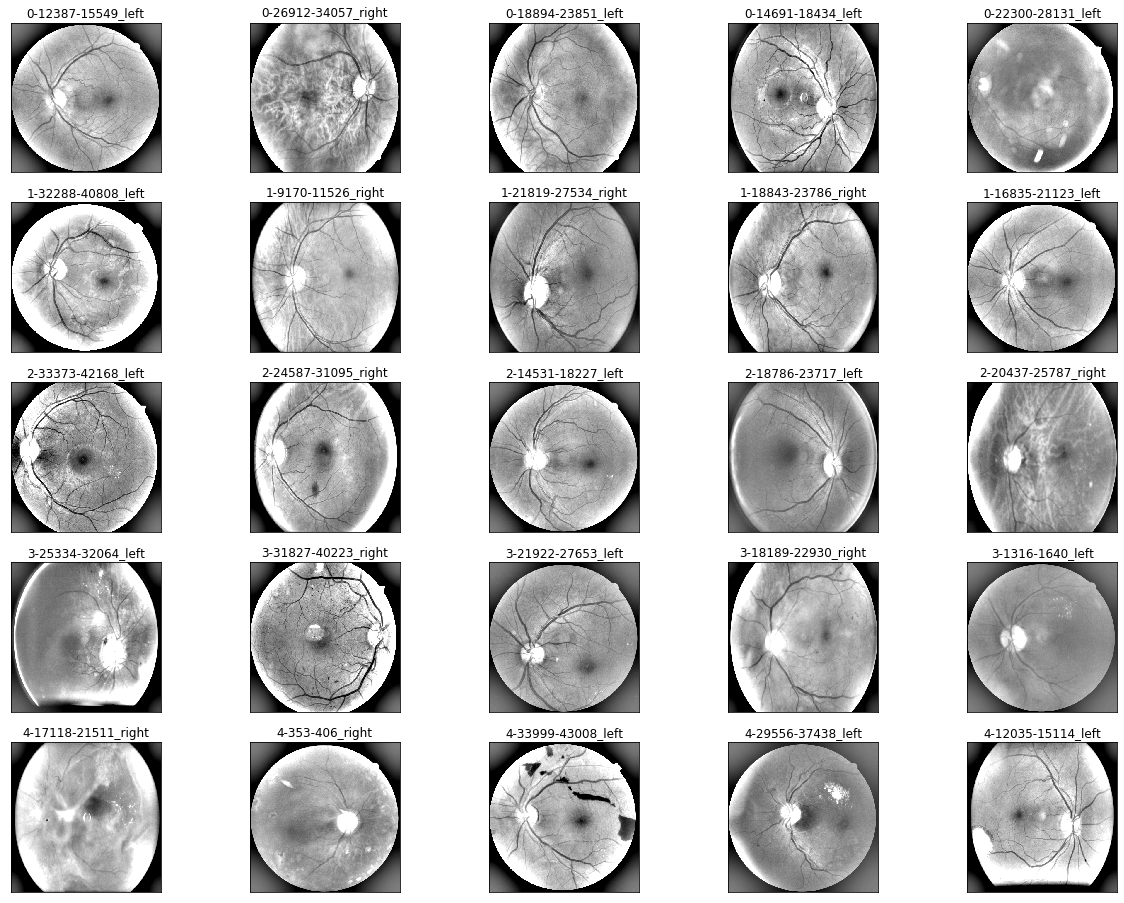

In [0]:
fig = plt.figure(figsize=(25, 16))

for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(dataset.loc[dataset['level'] == class_id].sample(5, random_state=32).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        image = cv2.imread(row['path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (512, 512))
        image = cv2.addWeighted(image,4, cv2.GaussianBlur(image, (0,0), 512/10), -4, 128)

        plt.imshow(image, cmap='gray')
        ax.set_title('%d-%d-%s' % (class_id, idx, row['image']) )